In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.models import Model,Sequential
from keras.optimizers import Adam,RMSprop
import pandas as pd
from keras.preprocessing.image import img_to_array
from keras.layers import *
import os
from keras.preprocessing import *

In [0]:
import os

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cartoon_data = os.listdir('drive/My Drive/cartoonset10k')


In [0]:
cartoon_data = os.listdir('drive/My Drive/cartoonset10k')

In [0]:
cartoon_img =[]

for i in range(20000):
    if cartoon_data[i][-3:] == 'png':
        cartoon_img.append(cartoon_data[i])

In [0]:
X_train = []
scale_percent = 25.6
width = 128
height = 128
dim = (width,height)
for i in cartoon_img:
    img = cv2.imread('drive/My Drive/cartoonset10k/' + i)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)
    X_train.append(resized_img)

In [0]:
X_train = np.array(X_train)

In [0]:
X_train = (X_train - 127.5)/127.5

In [0]:
## Discriminator

In [0]:


Discriminator = Sequential()

Discriminator.add(Conv2D(256,kernel_size = (5,5),strides=(2, 2), input_shape = (128,128,3)))
Discriminator.add(MaxPool2D())
Discriminator.add(LeakyReLU(0.2))
Discriminator.add(Conv2D(128,kernel_size = (5,5) ,strides=(2, 2)))
Discriminator.add(MaxPool2D())
Discriminator.add(LeakyReLU(0.2))
Discriminator.add(Flatten())
Discriminator.add(Dense(64, activation = LeakyReLU(0.2)))
Discriminator.add(Dense(32 , activation = LeakyReLU(0.2)))
Discriminator.add(Dense(1, activation = 'sigmoid'))

Discriminator.summary()


rmsprop = RMSprop(lr = 0.0004, clipvalue = 1.0, decay = 1e-8)

Discriminator.compile(optimizer=rmsprop , loss = 'binary_crossentropy')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 256)       19456     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 256)       0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       819328    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
Generator = Sequential()

adam = Adam(lr=2e-4,beta_1=0.5)
Generator.add(Dense( 8192, input_shape = (100,)))
Generator.add(Reshape((8,8,128)))
Generator.add(LeakyReLU(0.2))
Generator.add(Conv2DTranspose(64, kernel_size = (5,5) , strides = (2,2) , padding = 'same'))
Generator.add(BatchNormalization())
#Generator.add(Conv2DTranspose())
Generator.add(Conv2DTranspose(32, kernel_size = (5,5), strides = (2,2) , padding = 'same'))
Generator.add(BatchNormalization())
Generator.add(Conv2DTranspose(16, kernel_size = (5,5),  strides = (2,2) , padding = 'same'))
Generator.add(BatchNormalization())
Generator.add(Conv2DTranspose(3,  kernel_size =  (5,5) , padding = 'same' , strides = (2,2),activation = 'tanh'  ))



Generator.compile(loss = 'binary_crossentropy' , optimizer = adam)
Generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 16, 16, 64)        204864    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 32)        51232     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)       

In [0]:
Discriminator.trainable = False
gan_input = Input((100,))
fake_img = Generator(gan_input)
gan_output = Discriminator(fake_img)

model = Model(gan_input,gan_output)
rmsprop1 = RMSprop(lr = 0.0008,clipvalue = 1.0,decay = 1e-8) 
model.compile(loss = 'binary_crossentropy' , optimizer = rmsprop1)

In [0]:
#def generate_img():
batch_size = 64
half_batch = 32
def show_imgs(epoch):
    noise = np.random.randn(100,100)
    fake_imgs = Generator.predict(noise)
    fake_imgs = fake_imgs.reshape(100,128,128,3)

    # Plot
    plt.figure(figsize=(10,10))
    for i in range(100):
        plt.subplot(10,10,i+1)
        #fake_img[i] = cv2.cvtColor(fake_img[i],cv2.COLOR_BGR2RGB)
        plt.imshow(fake_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis("off")
    plt.show()

    plt.tight_layout()
    #plt.savefig('images/gan_output_{0}.png'.format(epoch+1))
def train_model():
    
    batch_size = 128
    half_batch = 64
    
    no_of_epoch = 50
    no_of_batch = int(8998/128)
    generator_loss = 0
    discriminator_loss = 0
    
    for epoch in range(no_of_epoch):
        generator_loss = 0
        discriminator_loss = 0
        for steps in range(no_of_batch):
        ## Training Discriminator
            X_real_d = X_train[np.random.randint(0,8998,half_batch)]
            y_real_d = np.ones((half_batch,1))*0.9

            X_fake_d = Generator.predict(np.random.randn(half_batch,100))
            y_fake_d = np.zeros((half_batch,1))

            #X_d = np.vstack((X_real_d,X_fake_d))
            #y_d = np.vstack((y_real_d,y_fake_d))

            d_loss_real = Discriminator.train_on_batch(X_real_d,y_real_d)
            d_loss_fake = Discriminator.train_on_batch(X_fake_d,y_fake_d)

            discriminator_loss += (d_loss_real+d_loss_fake)*0.5
            ## Training Generator 

            X_fake_g = np.random.normal(0,1,(batch_size,100))
            y_fake_g = np.ones((batch_size,1))*1.2

            g_loss = model.train_on_batch(X_fake_g,y_fake_g)
            generator_loss += g_loss
        
        print("%d D Loss %f. G Loss %f"%(epoch,discriminator_loss,generator_loss))
        
        if epoch%5 == 0:
            #print("discriminator loss {0} , Generator loss {0}".format(d,g_loss))
            show_imgs(epoch)
            model.save_weights('generator.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow w

0 D Loss 19.081107. G Loss 486.984862


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

1 D Loss 22.221047. G Loss 234.064548
2 D Loss 24.354031. G Loss 322.052062
3 D Loss 27.549428. G Loss 232.735772
4 D Loss 29.999618. G Loss 352.713692


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

5 D Loss 31.004686. G Loss 409.702301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

6 D Loss 28.677580. G Loss 426.359362
7 D Loss 30.648085. G Loss 420.716784
8 D Loss 29.077280. G Loss 421.647642
9 D Loss 26.518590. G Loss 474.957512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

10 D Loss 22.968320. G Loss 520.951798


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

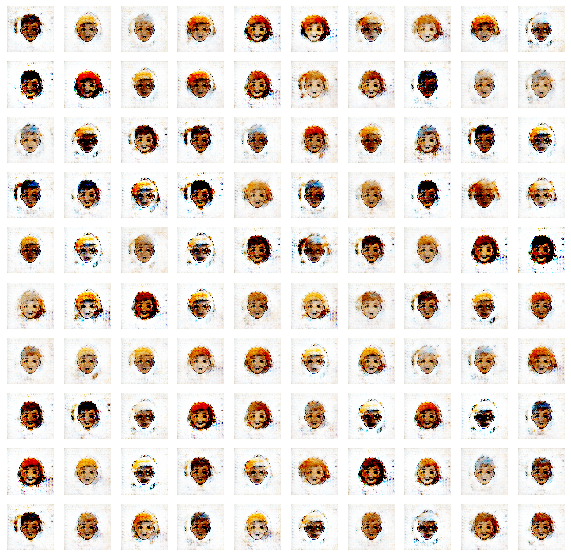

11 D Loss 24.518034. G Loss 483.665322
12 D Loss 24.737205. G Loss 585.452342
13 D Loss 19.978181. G Loss 538.283290
14 D Loss 19.061698. G Loss 624.218300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15 D Loss 19.889583. G Loss 449.039478


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

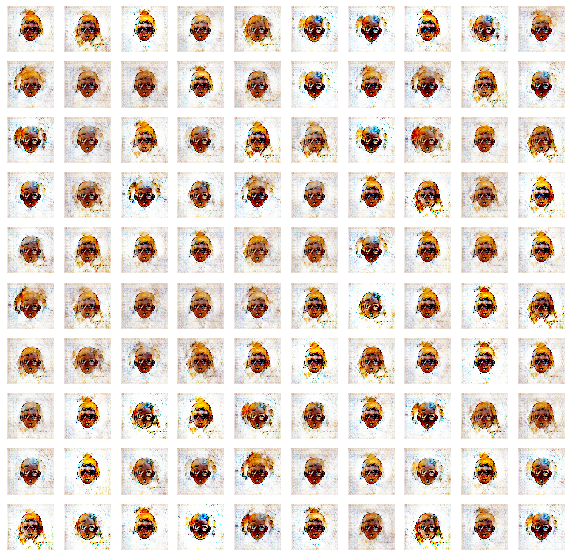

16 D Loss 21.949427. G Loss 599.715348
17 D Loss 18.090777. G Loss 634.579596
18 D Loss 19.487292. G Loss 624.348696
19 D Loss 21.504727. G Loss 597.773769


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

20 D Loss 19.641720. G Loss 623.744907


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

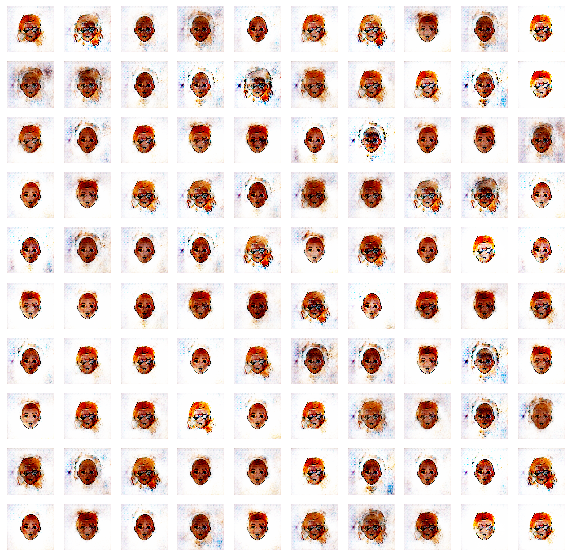

21 D Loss 20.374138. G Loss 581.066209
22 D Loss 20.472724. G Loss 636.359351
23 D Loss 20.773658. G Loss 696.599615
24 D Loss 20.391528. G Loss 615.540875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

25 D Loss 20.128979. G Loss 626.134668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

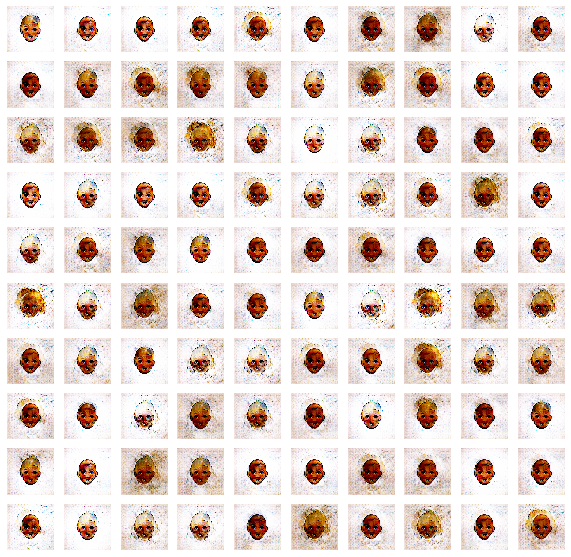

26 D Loss 19.436298. G Loss 661.896214
27 D Loss 23.021740. G Loss 622.449562
28 D Loss 18.929844. G Loss 687.880348
29 D Loss 18.487262. G Loss 679.029393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

30 D Loss 19.296258. G Loss 715.757432


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

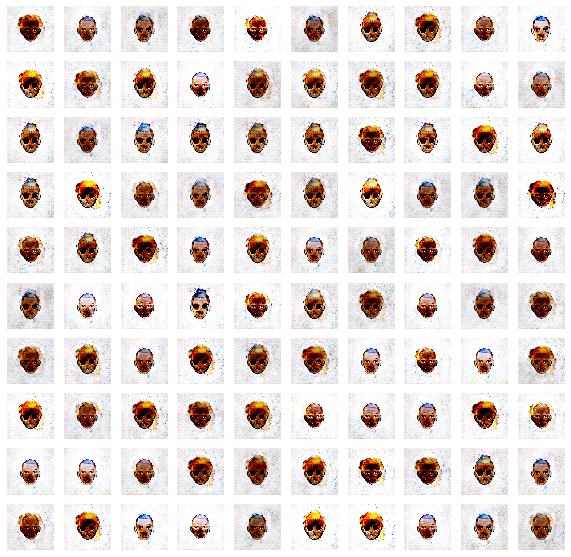

31 D Loss 18.570359. G Loss 686.158768
32 D Loss 18.670437. G Loss 691.059139
33 D Loss 19.002272. G Loss 698.334974
34 D Loss 20.282247. G Loss 677.757150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

35 D Loss 19.961173. G Loss 681.728286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

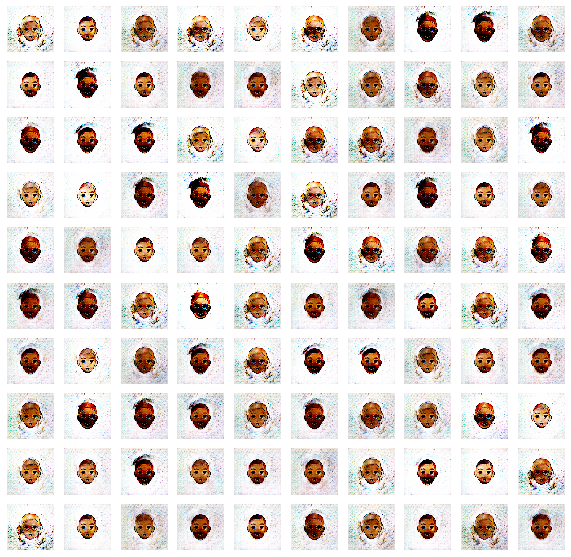

36 D Loss 19.163701. G Loss 674.794106
37 D Loss 16.904980. G Loss 706.777717
38 D Loss 19.696732. G Loss 691.952744
39 D Loss 16.603908. G Loss 676.139418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

40 D Loss 15.482443. G Loss 757.043297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

41 D Loss 21.889384. G Loss 687.361557
42 D Loss 20.006710. G Loss 674.349014
43 D Loss 16.987235. G Loss 742.995772
44 D Loss 17.009565. G Loss 795.789127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

45 D Loss 18.441933. G Loss 723.929317


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

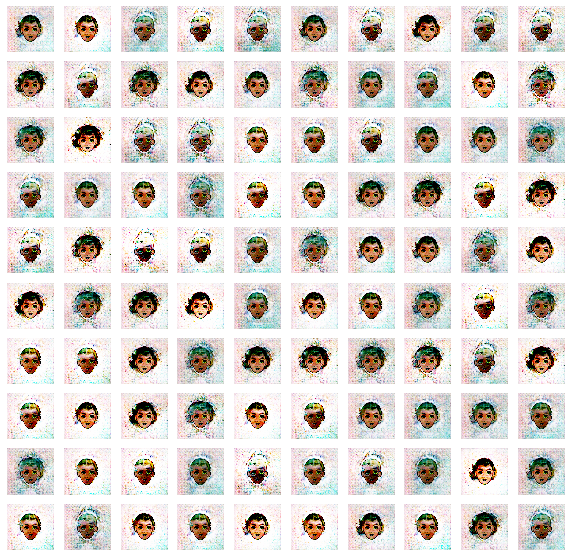

46 D Loss 18.361622. G Loss 747.213088
47 D Loss 19.668375. G Loss 732.180918
48 D Loss 16.907247. G Loss 713.308698
49 D Loss 16.693994. G Loss 776.626161


<Figure size 432x288 with 0 Axes>

In [0]:
train_model()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


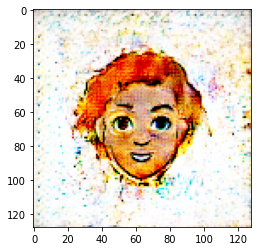

In [0]:
img_ = Generator.predict(np.random.randn(1,100))
img_ = img_[0]
#im_rgb = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
plt.imshow(img_)